In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from scipy.interpolate import BSpline

In [4]:
# Spline Function
class SplineFunction(nn.Module):
    def __init__(self, input_dim, num_knots):
        super(SplineFunction, self).__init__()
        self.num_knots = num_knots
        self.knots = nn.Parameter(torch.randn(num_knots, input_dim))
        self.coefs = nn.Parameter(torch.randn(num_knots, input_dim))
        nn.init.kaiming_normal_(self.coefs)
    def forward(self, x):
        # batch_size, input_dim = x.size()
        x_expanded = x.unsqueeze(1).expand(-1, self.num_knots, -1)
        knot_weights = torch.max(self.knots - x_expanded, torch.zeros_like(self.knots)).pow(3)
        output = torch.sum(knot_weights * self.coefs, dim=1)
        return output
    
class KANetwork(nn.Module):
    def __init__(self, input_dim, output_dim, num_knots=10):
        super(KANetwork, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_knots = num_knots
        self.input_splines = nn.ModuleList([SplineFunction(1, num_knots) for _ in range(input_dim)])
        self.output_splines = nn.ModuleList([SplineFunction(1, num_knots) for _ in range(output_dim)])
    def forward(self, x):
        x = x.view(x.shape[0], -1) 
        x = torch.cat([spline(x[:, i:i+1]) for i, spline in enumerate(self.input_splines)], dim=1)
        x = torch.cat([spline(x[:, i:i+1]) for i, spline in enumerate(self.output_splines)], dim=1)
        return x


model = KANetwork(input_dim=3, output_dim=10)

# x = torch.randn(5, 10, 1)  # (batch_size=5, seq_len=10, input_dim=2)
x = torch.randn(size=(3, 128, 128)) 
y = model(x)
# print(y.shape)  # Should be (5, 10, 1)

y

tensor([[  0.0000,   0.6201, 461.3328],
        [  0.0000,   0.0000, 225.1788],
        [  0.0000,   0.0000, 584.6589]], grad_fn=<CatBackward0>)

In [5]:
import torch.nn.functional as F
import numpy as np
from scipy.interpolate import BSpline

class BSplineFunction(nn.Module):
    def __init__(self, input_dim, num_knots, degree=3):
        super(BSplineFunction, self).__init__()
        self.num_knots = num_knots
        self.degree = degree

        # Define a uniform knot vector
        knots = np.linspace(-1, 1, num_knots + degree + 1)
        self.register_buffer("knots", torch.tensor(knots, dtype=torch.float32))  # Store as buffer

        # Trainable coefficients
        self.coefficients = nn.Parameter(torch.randn(num_knots, input_dim))
        nn.init.xavier_uniform_(self.coefficients, gain=0.01)  # Reduce gain


    def forward(self, x):
        batch_size, input_dim = x.shape
        x_np = x.detach().numpy() 

        # Compute B-Spline basis values
        basis_matrix = []
        for i in range(input_dim):
            basis_values = np.array([
                BSpline.basis_element(self.knots[j:j+self.degree+2].detach().numpy())(x_np[:, i])
                for j in range(self.num_knots)
            ])
            basis_matrix.append(torch.tensor(basis_values, dtype=torch.float32).T.to(x.device))  

        basis_matrix = torch.stack(basis_matrix, dim=-1)  # Shape: (batch_size, num_knots, input_dim)

        # Compute weighted sum of basis functions
        output = torch.sum(basis_matrix * self.coefficients, dim=1)
        return output

# KANetwork using B-Splines
class KANetwork(nn.Module):
    def __init__(self, input_dim, output_dim, num_knots=10, degree=3):
        super(KANetwork, self).__init__()
        self.input_splines = nn.ModuleList([BSplineFunction(1, num_knots, degree) for _ in range(input_dim)])
        self.output_splines = nn.ModuleList([BSplineFunction(1, num_knots, degree) for _ in range(output_dim)])

    def forward(self, x):
        # x = x.view(x.shape[0], -1)  # Flatten input
        x = torch.cat([spline(x[:, i:i+1]) for i, spline in enumerate(self.input_splines)], dim=1)
        x = torch.cat([spline(x[:, i:i+1]) for i, spline in enumerate(self.output_splines)], dim=1)
        return x

class Block(nn.Module):
    expansion: int = 2
    def __init__(self, input, output, identity_downsample=None, stride=(1,1)):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(input, output, kernel_size=(3,3), stride=(1,1), padding=1)
        self.bn1 = nn.BatchNorm2d(output)
        self.conv2 = nn.Conv2d(output, output*self.expansion, 
                               kernel_size=(3,3), stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(output*self.expansion,)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x = x + identity
        x = self.relu(x)
        return x
    
class ResNet_KAN(nn.Module):
    def __init__(self, block: Block, layers, input_shape, output_shape):
        super(ResNet_KAN, self).__init__()
        self.input = 16
        self.conv1 = nn.Conv2d(input_shape, 16, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=(1,1), padding=(1,1))

        ###ResNet Layers
        self.layer1 = self.make_layer(block,layers[0], output=16, stride=(2,2))
        self.layer2 = self.make_layer(block,layers[1], output=32, stride=(2,2))

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

        self.KANClassifier = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(32*block.expansion, 128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            KANetwork(128, 128),
            nn.Linear(128, output_shape)
        )
    
    def forward(self,x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)

        x = self.avgpool(x)

        x = self.KANClassifier(x)
        return x
    
    def make_layer(self, block, num_residual_MyBlocks, output, stride):
        identity_downsample = None
        layers = []

        if stride != 1 or self.input != output*block.expansion:
            identity_downsample = nn.Sequential(nn.Conv2d(
                self.input, output * block.expansion, kernel_size=(1,1), stride=stride),
                nn.BatchNorm2d(output*block.expansion)
            )
        layers.append(block(self.input, output, identity_downsample, stride))
        self.input = output*block.expansion

        for _ in range(num_residual_MyBlocks-1):
            layers.append(block(self.input, output))
        
        return nn.Sequential(*layers)


torch.manual_seed(23)
fsl_model = ResNet_KAN(Block, [2,2,2], input_shape=1, 
                       output_shape=10)
print(f"{fsl_model}")


# Count the total number of parameters
total_params = sum(p.numel() for p in fsl_model.parameters())
print(f"Total number of parameters: {total_params}")

ResNet_KAN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Block(
      (conv1): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), pa

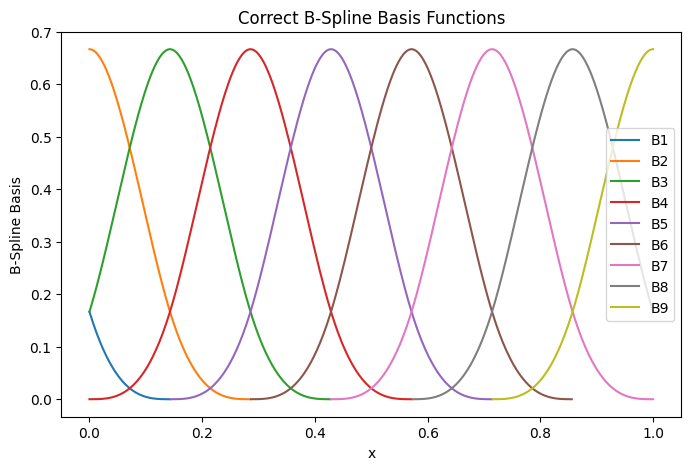

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline

def get_bsplines(x_bounds, n_fun, degree=3):
    """ Generates B-Spline basis functions for given bounds and number of functions. """
    grid_len = n_fun - degree + 1
    step = (x_bounds[1] - x_bounds[0]) / (grid_len - 1)
    edge_fun = {}

    # Define knot vector
    t = np.linspace(x_bounds[0] - degree * step, x_bounds[1] + degree * step, grid_len + 2 * degree)
    t[degree], t[-degree - 1] = x_bounds[0], x_bounds[1]

    for ind_spline in range(n_fun - 1):
        edge_fun[ind_spline + 1] = BSpline.basis_element(t[ind_spline:ind_spline + degree + 2], extrapolate=False)

    return edge_fun

# Define basis functions
x_bounds = [0, 1]
num_basis = 10
degree = 3
splines = get_bsplines(x_bounds, num_basis, degree)

# Compute B-spline basis matrix in PyTorch
x_vals = torch.linspace(x_bounds[0], x_bounds[1], 500)  # Sample input points
basis_matrix = torch.stack([torch.tensor(spline(x_vals.numpy()), dtype=torch.float32) for _, spline in splines.items()], dim=0)

# Plot the basis functions
plt.figure(figsize=(8, 5))
for i in range(basis_matrix.shape[0]):
    plt.plot(x_vals.numpy(), basis_matrix[i].numpy(), label=f'B{i+1}')

plt.xlabel("x")
plt.ylabel("B-Spline Basis")
plt.title("Correct B-Spline Basis Functions")
plt.legend()
plt.show()


In [7]:
import torch
import torch.nn.functional as F
import math

class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.reshape(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        output = base_output + spline_output
        
        output = output.reshape(*original_shape[:-1], self.out_features)
        return output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


In [8]:
model = KANLinear(in_features=3, out_features=10)

# x = torch.randn(5, 10, 1)  # (batch_size=5, seq_len=10, input_dim=2)
x = torch.randn(size=(1, 128 * 128, 3))
# x = torch.randn(size=(1, 128, 128)) 
y = model(x)
# print(y.shape)  # Should be (5, 10, 1)

y

tensor([[[-0.7857, -0.8337,  0.6744,  ...,  1.3821,  0.0338, -0.6709],
         [ 0.2621,  0.3931,  0.2640,  ...,  0.3403, -0.4262,  0.2841],
         [-0.4822, -0.2863,  0.6996,  ...,  1.3685, -0.3256, -0.1755],
         ...,
         [ 0.2005,  0.1706,  0.1231,  ...,  0.0960, -0.1837,  0.0651],
         [-0.1011, -0.0442, -0.0211,  ...,  0.0300,  0.0365,  0.0136],
         [ 0.0597,  0.0076, -0.1640,  ..., -0.3026,  0.1182, -0.0017]]],
       grad_fn=<ViewBackward0>)